# Case 1

## 1. Exploratory Data Analysis

Importing dependecies and packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install statsmodels
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading the dataset

In [3]:
df = pd.read_csv('TFP.csv')
df.head()

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179


In [4]:
df.shape

(186, 3)

Checking the countries present in the dataset

In [5]:
df['isocode'].value_counts()

USA    62
MEX    62
CAN    62
Name: isocode, dtype: int64

Checking the latest and earliest year, and the time period of the time series

In [6]:
print(max(df['year']))
print(min(df['year']))
print(max(df['year'])-min(df['year']))

2011
1950
61


Making a diff columns with the incremental differences from one year to another

In [7]:
def make_diff(x):
    return x.diff()

In [8]:
df['diff'] = df.groupby('isocode')['rtfpna'].apply(make_diff)
df.head()

,isocode,year,rtfpna,diff
0,USA,1950,0.617148,NaN
1,USA,1951,0.629588,0.012441
2,USA,1952,0.638451,0.008863
3,USA,1953,0.651858,0.013407
4,USA,1954,0.646179,-0.005679


Allocating a dataframe for each country.

In [9]:
usa_df = df[df['isocode'] == 'USA'].reset_index()
usa_df.head()

,index,isocode,year,rtfpna,diff
0,0,USA,1950,0.617148,NaN
1,1,USA,1951,0.629588,0.012441
2,2,USA,1952,0.638451,0.008863
3,3,USA,1953,0.651858,0.013407
4,4,USA,1954,0.646179,-0.005679


In [10]:
can_df = df[df['isocode'] == 'CAN'].reset_index()
can_df.head()

,index,isocode,year,rtfpna,diff
0,62,CAN,1950,0.843335,NaN
1,63,CAN,1951,0.855123,0.011788
2,64,CAN,1952,0.896489,0.041366
3,65,CAN,1953,0.910658,0.014169
4,66,CAN,1954,0.875178,-0.035480


In [11]:
mex_df = df[df['isocode'] == 'MEX'].reset_index()
mex_df.head()

,index,isocode,year,rtfpna,diff
0,124,MEX,1950,0.798159,NaN
1,125,MEX,1951,0.860931,0.062772
2,126,MEX,1952,0.876968,0.016036
3,127,MEX,1953,0.855204,-0.021763
4,128,MEX,1954,0.929168,0.073963


Allocating a dataframe for the aggregate of the countries (mean value of rtfpna)

In [12]:
agg_df=pd.DataFrame()
agg_df['year'] = usa_df['year']
agg_df['rtfpna'] = (mex_df['rtfpna'] + can_df['rtfpna'] + usa_df['rtfpna'])/3
agg_df['diff'] = (mex_df['diff'] + can_df['diff'] + usa_df['diff'])/3
agg_df.head()

,year,rtfpna,diff
0,1950,0.752881,NaN
1,1951,0.781881,0.029000
2,1952,0.803969,0.022089
3,1953,0.805907,0.001938
4,1954,0.816842,0.010935


Then, we plot the evolution of rtfpna for each country and the aggregate to check its behaviour

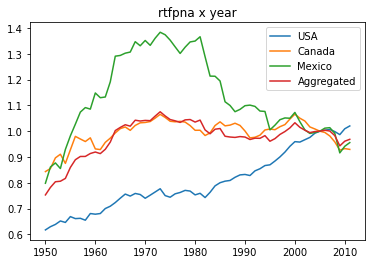

In [13]:
plt.plot(usa_df['year'], usa_df['rtfpna'], label='USA')
plt.plot(can_df['year'], can_df['rtfpna'], label='Canada')
plt.plot(mex_df['year'], mex_df['rtfpna'], label='Mexico')
plt.plot(agg_df['year'], agg_df['rtfpna'], label='Aggregated')
plt.title('rtfpna x year')
plt.legend()
plt.show()

We see that the rtfpna for the USA follows an increasing trend since 1950, while mexico has undergone a big up with a peak around 1970~1980 and now faces a drecreasing trend. Canada rtfpna has grown in the 50s and 60s but since then it is stable. The data suggests that the time-series are not stationary (the mean varies), hence, the I parameter of ARIMA should be at least 1.

Now we plot the variation from year to year for the rtfpna (we call it diff)

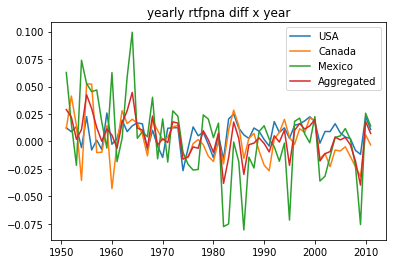

In [14]:
plt.plot(usa_df['year'], usa_df['diff'], label='USA')
plt.plot(can_df['year'], can_df['diff'], label='Canada')
plt.plot(mex_df['year'], mex_df['diff'], label='Mexico')
plt.plot(agg_df['year'], agg_df['diff'], label='Aggregated')
plt.title('yearly rtfpna diff x year')
plt.legend()
plt.show()

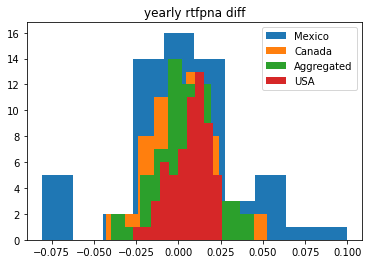

In [15]:
plt.hist(mex_df['diff'], label='Mexico', bins=10)
plt.hist(can_df['diff'], label='Canada', bins=10)
plt.hist(agg_df['diff'], label='Aggregated', bins=10)
plt.hist(usa_df['diff'], label='USA', bins=10)
plt.title('yearly rtfpna diff')
plt.legend()
plt.show()

We see that Mexico has the highest variace, followed by Canada, while the USA has the lowest variance, which means that the rtfpna value for the USA varies less from year to year than for Canada and Mexico.

Now, observing the moving average (window = 5 and window = 10) of the rtfpna for the countries and aggregates 

In [16]:
mex_df['ma5'] = mex_df['rtfpna'].rolling(5).sum()/5
can_df['ma5'] = can_df['rtfpna'].rolling(5).sum()/5
usa_df['ma5'] = usa_df['rtfpna'].rolling(5).sum()/5
agg_df['ma5'] = agg_df['rtfpna'].rolling(5).sum()/5
mex_df['ma10'] = mex_df['rtfpna'].rolling(10).sum()/10
can_df['ma10'] = can_df['rtfpna'].rolling(10).sum()/10
usa_df['ma10'] = usa_df['rtfpna'].rolling(10).sum()/10
agg_df['ma10'] = agg_df['rtfpna'].rolling(10).sum()/10

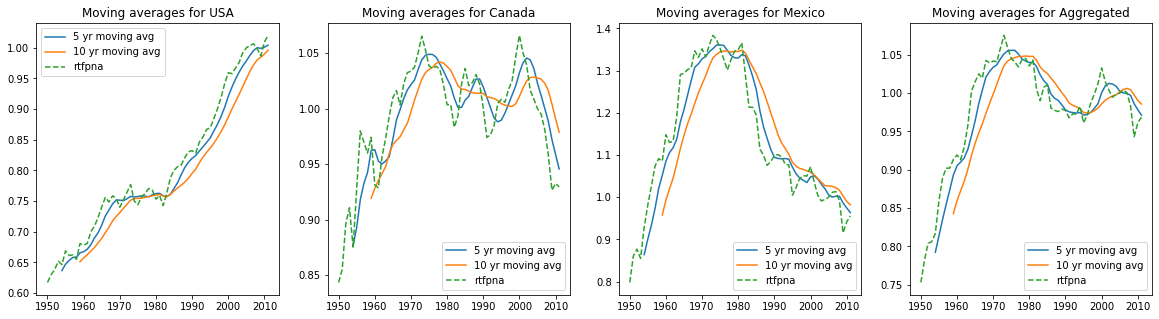

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))

countries = ['USA', 'Canada', 'Mexico', 'Aggregated']
for i, df1 in enumerate([usa_df, can_df, mex_df, agg_df]):
    ax[i].plot(df1['year'], df1['ma5'], label='5 yr moving avg')
    ax[i].plot(df1['year'], df1['ma10'], label = '10 yr moving avg')
    ax[i].plot(df1['year'], df1['rtfpna'], label = 'rtfpna', linestyle = '--')
    ax[i].title.set_text(f'Moving averages for {countries[i]}')
    ax[i].legend()


We note that the change in trends for the rtfpna over the year switch when the moving averages cross. For the USA graph, there isnt a trend change, but it stabelizes when the 5yr moving average (ma) equals the 10yr ma (from 1970 to 1980). For Canada we see that is starts with an increase, but when the 10yr ma crosses the 5yr from bottom to up, the rtfpna starts to decrease (around 1978), we see this trend change again around 1997 and 2005. For Mexico there is only one trend change and it happens aroung 1975 when the 10yr ma surpass the 5 yr ma. We see this trend changing behaviour also for the aggregated graph.

Plotting the autocorrelation graph for the rtfpna time-series

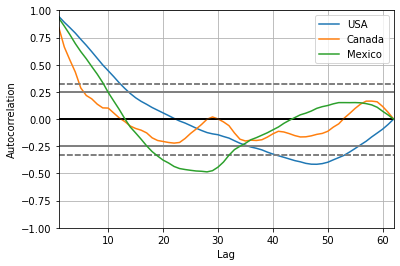

In [18]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(usa_df['rtfpna'], label = 'USA')
autocorrelation_plot(can_df['rtfpna'], label = 'Canada')
autocorrelation_plot(mex_df['rtfpna'], label = 'Mexico')
plt.legend()

We note that there is a positive auto-correlation of around 22 lag values for the USA, 12 for Canada and 13 for Mexico. The auto-correlations are very high for values around 5~10. This should be reflected at the AR parameter of the ARIMA model.

## 2. Forecasting 10 yrs

Creating the ARIMA model

Test RMSE: 0.017


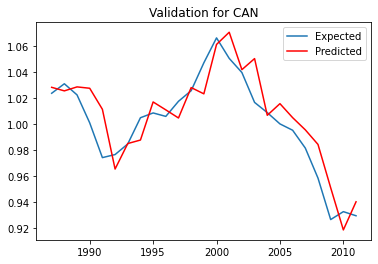

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1826: RuntimeWarning: invalid value encountered in sqrt
  fcerr = np.sqrt(np.cumsum(cumsum_n(ma_rep, self.k_diff)**2)*sigma2)
/usr/local/lib

Test RMSE: 0.043


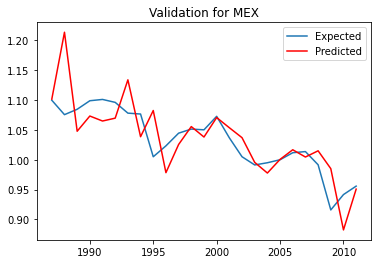

Test RMSE: 0.010


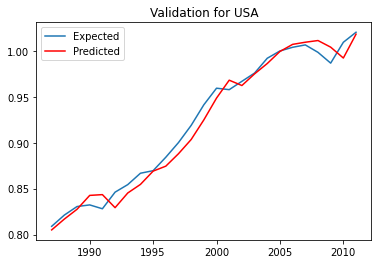

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

arima_par = [[7, 1, 0], [10, 1, 0], [12, 1, 0]]

for group, par in zip(df.groupby('isocode'), arima_par):
  country = group[0]
  df1 = group[1]
  size = int(df1.shape[0] * 0.6)
  train, test = df1['rtfpna'][0:size], df1['rtfpna'][size:df1.shape[0]]
  years = df1['year'][size:df1.shape[0]]
  train = list(train)
  test = list(test)
  history = [x for x in train]
  predictions = list()

  for t in range(len(test)):
    model = sm.tsa.ARIMA(history, order=(par[0],par[1],par[2]))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

  rmse = sqrt(mean_squared_error(test, predictions))
  print('Test RMSE: %.3f' % rmse)

  plt.plot(years, test, label='Expected')
  plt.plot(years, predictions, color='red', label='Predicted')
  plt.title(f"Validation for {country}")
  plt.legend()
  plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


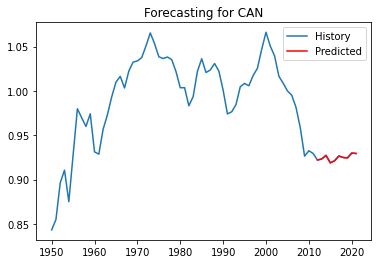

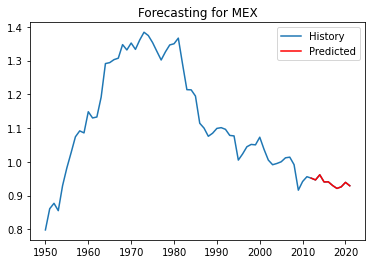

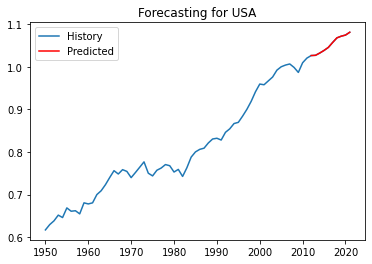

In [20]:
pred_df = pd.DataFrame(columns=['isocode','year','rtfpna'])
i = 0
for group, par in zip(df.groupby('isocode'), arima_par):
  country = group[0]
  df1 = group[1]
  history = list(df1['rtfpna'])
  years = range(1950,2022)
  years1 = range(2012,2022)
  predictions = list()

  for t in range(10):
    model = sm.tsa.ARIMA(history, order=(par[0],par[1],par[2]))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

    pred_df.loc[t+10*i, 'isocode'] = country
    pred_df.loc[t+10*i, 'year'] = 2012+t
    pred_df.loc[t+10*i, 'rtfpna'] = yhat[0] 
  i += 1
  plt.plot(years, history, label='History')
  plt.plot(years1, predictions, color='red', label='Predicted')
  plt.title(f"Forecasting for {country}")
  plt.legend()
  plt.show()

In [21]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(pred_df)

   isocode  year    rtfpna
0      CAN  2012  0.922099
1      CAN  2013  0.923286
2      CAN  2014  0.927338
3      CAN  2015   0.91891
4      CAN  2016  0.921312
5      CAN  2017  0.926648
6      CAN  2018  0.924983
7      CAN  2019  0.924441
8      CAN  2020  0.929989
9      CAN  2021  0.929472
10     MEX  2012   0.95152
11     MEX  2013  0.946222
12     MEX  2014  0.961455
13     MEX  2015  0.940245
14     MEX  2016   0.94057
15     MEX  2017  0.929665
16     MEX  2018  0.921111
17     MEX  2019  0.925718
18     MEX  2020  0.939015
19     MEX  2021  0.928959
20     USA  2012   1.02634
21     USA  2013   1.02689
22     USA  2014   1.03226
23     USA  2015   1.03838
24     USA  2016   1.04544
25     USA  2017   1.05703
26     USA  2018   1.06786
27     USA  2019   1.07178
28     USA  2020   1.07439
29     USA  2021   1.08104


#3. Feature addition

Checking all the possible values to add to the forecasting, we choose the xr (exchange rate national currency/USD) since the exchange rate oscilated during the years, and are not necesseraly correlated.